# Chapter 2 : 介入効果を測るための回帰分析

In [1]:
## create the clean environment
import gc
import matplotlib.pyplot as plt

def clear_all():
    # Clears all the variables from the workspace
    gl = globals().copy()
    for var in gl:
        if var in clean_env_var: continue
        del globals()[var]
    # Garbage collection:
    gc.collect()

def close_plots():
  my_plots = plt.get_fignums()
  for j in my_plots:
    plt.close(plt.figure(j))

clean_env_var = dir()
clean_env_var.append('clean_env_var')

In [2]:
clear_all()

## この章で学ぶこと

- 回帰分析を用いて、セレクションバイアスの影響を低減させることができることを確認する
- OLS理論は同じディレクトリにある`OLS_review.ipynb`参照すること

Python version

In [3]:
import sys
print(sys.version)

3.7.4 (default, Sep  7 2019, 18:45:40) 
[Clang 9.0.0 (clang-900.0.39.2)]


Install Packages

In [4]:
pass

Import

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp
from patsy import dmatrices

## 2.1.5 メールマーケティングデータの分析（回帰編）

In [6]:
df = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
recency            64000 non-null int64
history_segment    64000 non-null object
history            64000 non-null float64
mens               64000 non-null int64
womens             64000 non-null int64
zip_code           64000 non-null object
newbie             64000 non-null int64
channel            64000 non-null object
segment            64000 non-null object
visit              64000 non-null int64
conversion         64000 non-null int64
spend              64000 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.009031,1.050908
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.094604,15.036448
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000


バイアスのあるデータを作成

In [7]:
## 前処理

df.loc[:, 'treatment'] = df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df = df.loc[df['segment'] != 'Womens E-Mail']
male_df.info()
male_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42613 entries, 1 to 63999
Data columns (total 13 columns):
recency            42613 non-null int64
history_segment    42613 non-null object
history            42613 non-null float64
mens               42613 non-null int64
womens             42613 non-null int64
zip_code           42613 non-null object
newbie             42613 non-null int64
channel            42613 non-null object
segment            42613 non-null object
visit              42613 non-null int64
conversion         42613 non-null int64
spend              42613 non-null float64
treatment          42613 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 4.6+ MB


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


In [8]:
def bias(s):
  loyal = s['history'] > 300 or s['recency'] < 3 or s['channel'] == 'Multichannel'
  if (s['treatment'] == 1 and not loyal) or (s['treatment'] == 0 and loyal):
    return 0.5
  else:
    return 1.0

biased_data = male_df.sample(frac=0.5, weights=male_df.apply(bias, axis=1), random_state=10101)
biased_data.info()
biased_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21306 entries, 55120 to 61819
Data columns (total 13 columns):
recency            21306 non-null int64
history_segment    21306 non-null object
history            21306 non-null float64
mens               21306 non-null int64
womens             21306 non-null int64
zip_code           21306 non-null object
newbie             21306 non-null int64
channel            21306 non-null object
segment            21306 non-null object
visit              21306 non-null int64
conversion         21306 non-null int64
spend              21306 non-null float64
treatment          21306 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 2.3+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend,treatment
count,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000
mean,5.759035,242.856311,0.549141,0.552051,0.501877,0.148033,0.010091,1.176565,0.488548
std,3.508750,261.838024,0.497591,0.497295,0.500008,0.355141,0.099948,16.115077,0.499881
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.902500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,156.050000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,323.817500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000,1.000000


In [9]:
## OLSをstatsmodels apiで実行
y, X = dmatrices('spend ~ treatment + history', data = biased_data, return_type='dataframe')

model = sm.OLS(y, X)
res = model.fit()

In [10]:
summary = res.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.91
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           6.77e-06
Time:                        07:54:36   Log-Likelihood:                -89445.
No. Observations:               21306   AIC:                         1.789e+05
Df Residuals:                   21303   BIC:                         1.789e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4970      0.178      2.793      0.0

### REMARKS
- Rの実行結果と異なる理由は、biased_data作成がランダムサンプルのため

In [11]:
## 推定されたパラメーターを取り出す
coef = summary.tables[1]
print(type(coef))
print(coef)

<class 'statsmodels.iolib.table.SimpleTable'>
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4970      0.178      2.793      0.005       0.148       0.846
treatment      0.7930      0.223      3.560      0.000       0.356       1.230
history        0.0012      0.000      2.828      0.005       0.000       0.002


In [12]:
coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4970,0.178,2.793,0.005,0.148,0.846
treatment,0.7930,0.223,3.560,0.000,0.356,1.230
history,0.0012,0.000,2.828,0.005,0.000,0.002


なおパラメータのみを取り出したいときは

In [13]:
print(res.params)

Intercept    0.497024
treatment    0.793040
history      0.001203
dtype: float64


residualも一応計算

In [14]:
beta = res.params.values
beta.shape = 3, 1
beta.shape
residual = y.values - X.values @ beta 

In [15]:
residual.shape

(21306, 1)

In [16]:
np.mean(residual)

-4.473624553919219e-14

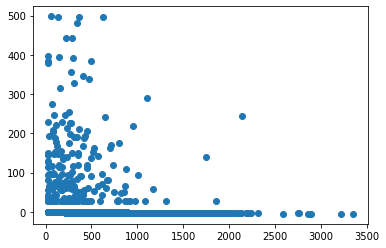

In [17]:
plt.scatter(X['history'], residual);

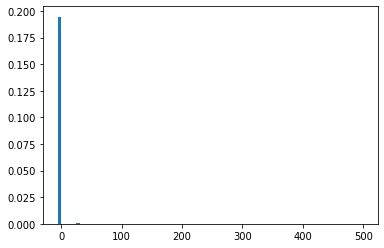

In [18]:
plt.hist(residual, bins = np.linspace(np.min(residual), np.max(residual), 100), density = True);

不均一分散は言わずもがななので、本当はwhite robust standard errorを用いてt検定をすべき[TODO]

## 2.2 回帰分析におけるバイアス

In [19]:
## RCTデータでの単回帰
y, X = dmatrices('spend ~ treatment', data = male_df, return_type = 'dataframe')
results = sm.OLS(y, X).fit()
rct_reg_coef = results.summary().tables[1]
rct_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6528,0.103,6.356,0.000,0.451,0.854
treatment,0.7698,0.145,5.300,0.000,0.485,1.055


In [20]:
## バイアスのあるデータでの単回帰
y, X = dmatrices('spend ~ treatment', data = biased_data, return_type = 'dataframe')
results = sm.OLS(y, X).fit()
rct_reg_coef = results.summary().tables[1]
rct_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7476,0.154,4.844,0.000,0.445,1.050
treatment,0.8781,0.221,3.977,0.000,0.445,1.311


In [21]:
## バイアスのあるデータでの重回帰
y, X = dmatrices('spend ~ treatment + recency + channel + history', data = biased_data, return_type = 'dataframe')
results = sm.OLS(y, X).fit()
biased_reg_coef = results.summary().tables[1]
biased_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7007,0.473,1.482,0.138,-0.226,1.628
channel[T.Phone],0.4307,0.391,1.101,0.271,-0.336,1.197
channel[T.Web],0.4668,0.391,1.195,0.232,-0.299,1.232
treatment,0.7466,0.224,3.333,0.001,0.308,1.186
recency,-0.0966,0.033,-2.966,0.003,-0.160,-0.033
history,0.0011,0.000,2.366,0.018,0.000,0.002


### REMARKS

dmatricesはカテゴリ変数のダミー変数化も勝手にやってくれる


## 2.2.3 OVBの確認

broomのpython alternativeがわからない

In [22]:
y_biased, X_biased = dmatrices('spend ~ treatment + recency + channel', data = biased_data, return_type = 'dataframe')
y_full, X_full = dmatrices('spend ~ treatment + recency + channel + history', data = biased_data, return_type = 'dataframe')
y_his, X_his = dmatrices('history ~ treatment + recency + channel', data = biased_data, return_type = 'dataframe')

In [23]:
dataset = [(y_biased, X_biased), (y_full, X_full), (y_his, X_his)]

In [24]:
for i, j in dataset:
    results = sm.OLS(i, j).fit()
    print(results.summary().tables[1])

                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.3455      0.386      3.482      0.000       0.588       2.103
channel[T.Phone]     0.0902      0.364      0.248      0.804      -0.623       0.803
channel[T.Web]       0.1287      0.364      0.354      0.723      -0.584       0.841
treatment            0.7892      0.223      3.534      0.000       0.351       1.227
recency             -0.1130      0.032     -3.551      0.000      -0.175      -0.051
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7007      0.473      1.482      0.138      -0.226       1.628
channel[T.Phone]     0.4307      0.391      1.101      0.271      -0.336       1.197
channel[T.Web]       0.4668      0.391      1.195      0.232     